In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Importing all the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [3]:
use_gpu = torch.cuda.is_available()

In [4]:
use_gpu

True

## Building the model
We first apply a number of convolutional layers to extract features from our image, and then we apply deconvolutional layers to upscale of our features.
Activation function used is ReLu since it is simple and easy to work to give efficient results.

In [5]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [6]:
model = ColorizationNet()

## Loss Function - MSE loss

In [7]:
criterion = nn.MSELoss()

## Adam optimizer

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

## Conversion of RGB images to LAB components to extract L and ab components separately in order to train the L channel to predict a and b channel

In [9]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    print(path, target)
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

## Training and Validation split of Dataset in order to train the model and validate data to calculate the similarities between images.

In [10]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('/content/drive/MyDrive/Ani/Training', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('/content/drive/MyDrive/Val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [11]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf()
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy()
  color_image = color_image.transpose((1, 2, 0))  
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

## Validation of the data and storing the images of each epoch into an output folder which contains coloured images and grayscale images.

In [12]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

## Running the model and backpropagate using loss.backward() to compute the gradient

In [150]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # time to load data (above)
    data_time.update(time.time() - end)

    # Updating the losses
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Back propagation to compute gradient
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    #model accuracy
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [14]:
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [15]:
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 30


## Running each epoch in order to save the transition of colourisation of images from scratch

In [16]:
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
/content/drive/MyDrive/Ani/Training/class/64.jpg 0
/content/drive/MyDrive/Ani/Training/class/79.jpg 0
/content/drive/MyDrive/Ani/Training/class/69.jpg 0
/content/drive/MyDrive/Ani/Training/class/67.jpg 0
/content/drive/MyDrive/Ani/Training/class/18.jpg 0
/content/drive/MyDrive/Ani/Training/class/68.jpg 0
/content/drive/MyDrive/Ani/Training/class/81.jpg 0
/content/drive/MyDrive/Ani/Training/class/25.jpg 0
/content/drive/MyDrive/Ani/Training/class/50.jpg 0
/content/drive/MyDrive/Ani/Training/class/7.jpg 0
/content/drive/MyDrive/Ani/Training/class/72.jpg 0
/content/drive/MyDrive/Ani/Training/class/28.jpg 0
/content/drive/MyDrive/Ani/Training/class/36.jpg 0
/content/drive/MyDrive/Ani/Training/class/4.jpg 0
/content/drive/MyDrive/Ani/Training/class/63.jpg 0
/content/drive/MyDrive/Ani/Training/class/55.jpg 0
/content/drive/MyDrive/Ani/Training/class/70.jpg 0
/content/drive/MyDrive/Ani/Training/class/19.jpg 0
/content/drive/MyDrive/Ani/Training/class/75.jpg 0
/conten

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 50176 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/1]	Time 1.035 (1.035)	Loss 12204974.0000 (12204974.0000)	
Finished validation.
Starting training epoch 1
/content/drive/MyDrive/Ani/Training/class/64.jpg 0
/content/drive/MyDrive/Ani/Training/class/41.jpg 0
/content/drive/MyDrive/Ani/Training/class/62.jpg 0
/content/drive/MyDrive/Ani/Training/class/54.jpg 0
/content/drive/MyDrive/Ani/Training/class/70.jpg 0
/content/drive/MyDrive/Ani/Training/class/30.jpg 0
/content/drive/MyDrive/Ani/Training/class/26.jpg 0
/content/drive/MyDrive/Ani/Training/class/8.jpg 0
/content/drive/MyDrive/Ani/Training/class/10.jpg 0
/content/drive/MyDrive/Ani/Training/class/6.jpg 0
/content/drive/MyDrive/Ani/Training/class/68.jpg 0
/content/drive/MyDrive/Ani/Training/class/28.jpg 0
/content/drive/MyDrive/Ani/Training/class/32.jpg 0
/content/drive/MyDrive/Ani/Training/class/65.jpg 0
/content/drive/MyDrive/Ani/Training/class/21.jpg 0
/content/drive/MyDrive/Ani/Training/class/48.jpg 0
/content/drive/MyDrive/Ani/Training/class/39.jpg 0
/content/drive/My

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1124 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 932 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 924 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/1]	Time 0.190 (0.190)	Loss 10050523.0000 (10050523.0000)	
Finished validation.
Starting training epoch 2
/content/drive/MyDrive/Ani/Training/class/25.jpg 0
/content/drive/MyDrive/Ani/Training/class/52.jpg 0
/content/drive/MyDrive/Ani/Training/class/23.jpg 0
/content/drive/MyDrive/Ani/Training/class/76.jpg 0
/content/drive/MyDrive/Ani/Training/class/59.jpg 0
/content/drive/MyDrive/Ani/Training/class/69.jpg 0
/content/drive/MyDrive/Ani/Training/class/27.jpg 0
/content/drive/MyDrive/Ani/Training/class/11.jpg 0
/content/drive/MyDrive/Ani/Training/class/45.jpg 0
/content/drive/MyDrive/Ani/Training/class/65.jpg 0
/content/drive/MyDrive/Ani/Training/class/72.jpg 0
/content/drive/MyDrive/Ani/Training/class/78.jpg 0
/content/drive/MyDrive/Ani/Training/class/81.jpg 0
/content/drive/MyDrive/Ani/Training/class/21.jpg 0
/content/drive/MyDrive/Ani/Training/class/18.jpg 0
/content/drive/MyDrive/Ani/Training/class/66.jpg 0
/content/drive/MyDrive/Ani/Training/class/24.jpg 0
/content/drive/

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 20 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 16 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


/content/drive/MyDrive/Ani/Training/class/35.jpg 0
/content/drive/MyDrive/Ani/Training/class/31.jpg 0
/content/drive/MyDrive/Ani/Training/class/4.jpg 0
/content/drive/MyDrive/Ani/Training/class/39.jpg 0
/content/drive/MyDrive/Ani/Training/class/38.jpg 0
/content/drive/MyDrive/Ani/Training/class/64.jpg 0
/content/drive/MyDrive/Ani/Training/class/27.jpg 0
/content/drive/MyDrive/Ani/Training/class/1.jpg 0
/content/drive/MyDrive/Ani/Training/class/2.jpg 0
/content/drive/MyDrive/Ani/Training/class/24.jpg 0
/content/drive/MyDrive/Ani/Training/class/29.jpg 0
/content/drive/MyDrive/Ani/Training/class/55.jpg 0
/content/drive/MyDrive/Ani/Training/class/22.jpg 0
/content/drive/MyDrive/Ani/Training/class/63.jpg 0
/content/drive/MyDrive/Ani/Training/class/11.jpg 0
/content/drive/MyDrive/Ani/Training/class/51.jpg 0
/content/drive/MyDrive/Ani/Training/class/43.jpg 0
/content/drive/MyDrive/Ani/Training/class/18.jpg 0
/content/drive/MyDrive/Ani/Training/class/72.jpg 0
/content/drive/MyDrive/Ani/Trainin

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 976 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 912 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Starting training epoch 4
/content/drive/MyDrive/Ani/Training/class/33.jpg 0
/content/drive/MyDrive/Ani/Training/class/18.jpg 0
/content/drive/MyDrive/Ani/Training/class/23.jpg 0
/content/drive/MyDrive/Ani/Training/class/34.jpg 0
/content/drive/MyDrive/Ani/Training/class/15.jpg 0
/content/drive/MyDrive/Ani/Training/class/45.jpg 0
/content/drive/MyDrive/Ani/Training/class/71.jpg 0
/content/drive/MyDrive/Ani/Training/class/80.jpg 0
/content/drive/MyDrive/Ani/Training/class/60.jpg 0
/content/drive/MyDrive/Ani/Training/class/73.jpg 0
/content/drive/MyDrive/Ani/Training/class/55.jpg 0
/content/drive/MyDrive/Ani/Training/class/79.jpg 0
/content/drive/MyDrive/Ani/Training/class/48.jpg 0
/content/drive/MyDrive/Ani/Training/class/11.jpg 0
/content/drive/MyDrive/Ani/Training/class/78.jpg 0
/content/drive/MyDrive/Ani/Training/class/16.jpg 0
/content/drive/MyDrive/Ani/Training/class/51.jpg 0
/content/drive/MyDrive/Ani/Training/class/28.jpg 0
/content/drive/MyDrive/Ani/Training/class/76.jpg 0
/cont

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49932 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 50116 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 50100 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


/content/drive/MyDrive/Ani/Training/class/74.jpg 0
/content/drive/MyDrive/Ani/Training/class/24.jpg 0
/content/drive/MyDrive/Ani/Training/class/20.jpg 0
/content/drive/MyDrive/Ani/Training/class/80.jpg 0
/content/drive/MyDrive/Ani/Training/class/3.jpg 0
/content/drive/MyDrive/Ani/Training/class/8.jpg 0
/content/drive/MyDrive/Ani/Training/class/14.jpg 0
/content/drive/MyDrive/Ani/Training/class/31.jpg 0
/content/drive/MyDrive/Ani/Training/class/9.jpg 0
/content/drive/MyDrive/Ani/Training/class/32.jpg 0
/content/drive/MyDrive/Ani/Training/class/22.jpg 0
/content/drive/MyDrive/Ani/Training/class/58.jpg 0
/content/drive/MyDrive/Ani/Training/class/42.jpg 0
/content/drive/MyDrive/Ani/Training/class/5.jpg 0
/content/drive/MyDrive/Ani/Training/class/73.jpg 0
/content/drive/MyDrive/Ani/Training/class/50.jpg 0
/content/drive/MyDrive/Ani/Training/class/79.jpg 0
/content/drive/MyDrive/Ani/Training/class/29.jpg 0
/content/drive/MyDrive/Ani/Training/class/63.jpg 0
/content/drive/MyDrive/Ani/Training

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 50014 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 50172 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49604 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Starting training epoch 6
/content/drive/MyDrive/Ani/Training/class/16.jpg 0
/content/drive/MyDrive/Ani/Training/class/69.jpg 0
/content/drive/MyDrive/Ani/Training/class/67.jpg 0
/content/drive/MyDrive/Ani/Training/class/41.jpg 0
/content/drive/MyDrive/Ani/Training/class/23.jpg 0
/content/drive/MyDrive/Ani/Training/class/71.jpg 0
/content/drive/MyDrive/Ani/Training/class/49.jpg 0
/content/drive/MyDrive/Ani/Training/class/44.jpg 0
/content/drive/MyDrive/Ani/Training/class/51.jpg 0
/content/drive/MyDrive/Ani/Training/class/6.jpg 0
/content/drive/MyDrive/Ani/Training/class/28.jpg 0
/content/drive/MyDrive/Ani/Training/class/70.jpg 0
/content/drive/MyDrive/Ani/Training/class/2.jpg 0
/content/drive/MyDrive/Ani/Training/class/33.jpg 0
/content/drive/MyDrive/Ani/Training/class/43.jpg 0
/content/drive/MyDrive/Ani/Training/class/57.jpg 0
/content/drive/MyDrive/Ani/Training/class/20.jpg 0
/content/drive/MyDrive/Ani/Training/class/66.jpg 0
/content/drive/MyDrive/Ani/Training/class/29.jpg 0
/conten

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 48698 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 50168 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49109 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Starting training epoch 7
/content/drive/MyDrive/Ani/Training/class/29.jpg 0
/content/drive/MyDrive/Ani/Training/class/64.jpg 0
/content/drive/MyDrive/Ani/Training/class/56.jpg 0
/content/drive/MyDrive/Ani/Training/class/32.jpg 0
/content/drive/MyDrive/Ani/Training/class/73.jpg 0
/content/drive/MyDrive/Ani/Training/class/60.jpg 0
/content/drive/MyDrive/Ani/Training/class/23.jpg 0
/content/drive/MyDrive/Ani/Training/class/44.jpg 0
/content/drive/MyDrive/Ani/Training/class/40.jpg 0
/content/drive/MyDrive/Ani/Training/class/70.jpg 0
/content/drive/MyDrive/Ani/Training/class/76.jpg 0
/content/drive/MyDrive/Ani/Training/class/48.jpg 0
/content/drive/MyDrive/Ani/Training/class/37.jpg 0
/content/drive/MyDrive/Ani/Training/class/50.jpg 0
/content/drive/MyDrive/Ani/Training/class/66.jpg 0
/content/drive/MyDrive/Ani/Training/class/42.jpg 0
/content/drive/MyDrive/Ani/Training/class/58.jpg 0
/content/drive/MyDrive/Ani/Training/class/52.jpg 0
/content/drive/MyDrive/Ani/Training/class/26.jpg 0
/cont

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 46674 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 50142 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 48789 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Starting training epoch 8
/content/drive/MyDrive/Ani/Training/class/14.jpg 0
/content/drive/MyDrive/Ani/Training/class/50.jpg 0
/content/drive/MyDrive/Ani/Training/class/22.jpg 0
/content/drive/MyDrive/Ani/Training/class/36.jpg 0
/content/drive/MyDrive/Ani/Training/class/26.jpg 0
/content/drive/MyDrive/Ani/Training/class/71.jpg 0
/content/drive/MyDrive/Ani/Training/class/23.jpg 0
/content/drive/MyDrive/Ani/Training/class/20.jpg 0
/content/drive/MyDrive/Ani/Training/class/57.jpg 0
/content/drive/MyDrive/Ani/Training/class/35.jpg 0
/content/drive/MyDrive/Ani/Training/class/11.jpg 0
/content/drive/MyDrive/Ani/Training/class/43.jpg 0
/content/drive/MyDrive/Ani/Training/class/67.jpg 0
/content/drive/MyDrive/Ani/Training/class/18.jpg 0
/content/drive/MyDrive/Ani/Training/class/44.jpg 0
/content/drive/MyDrive/Ani/Training/class/41.jpg 0
/content/drive/MyDrive/Ani/Training/class/40.jpg 0
/content/drive/MyDrive/Ani/Training/class/12.jpg 0
/content/drive/MyDrive/Ani/Training/class/51.jpg 0
/cont

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 40864 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 47206 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 42921 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/1]	Time 0.173 (0.173)	Loss 24.3706 (24.3706)	
Finished validation.
Starting training epoch 9
/content/drive/MyDrive/Ani/Training/class/38.jpg 0
/content/drive/MyDrive/Ani/Training/class/48.jpg 0
/content/drive/MyDrive/Ani/Training/class/31.jpg 0
/content/drive/MyDrive/Ani/Training/class/41.jpg 0
/content/drive/MyDrive/Ani/Training/class/52.jpg 0
/content/drive/MyDrive/Ani/Training/class/24.jpg 0
/content/drive/MyDrive/Ani/Training/class/25.jpg 0
/content/drive/MyDrive/Ani/Training/class/65.jpg 0
/content/drive/MyDrive/Ani/Training/class/69.jpg 0
/content/drive/MyDrive/Ani/Training/class/13.jpg 0
/content/drive/MyDrive/Ani/Training/class/30.jpg 0
/content/drive/MyDrive/Ani/Training/class/46.jpg 0
/content/drive/MyDrive/Ani/Training/class/27.jpg 0
/content/drive/MyDrive/Ani/Training/class/64.jpg 0
/content/drive/MyDrive/Ani/Training/class/12.jpg 0
/content/drive/MyDrive/Ani/Training/class/3.jpg 0
/content/drive/MyDrive/Ani/Training/class/16.jpg 0
/content/drive/MyDrive/Ani/T

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2143 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4327 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4955 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/1]	Time 0.192 (0.192)	Loss 60.4139 (60.4139)	
Finished validation.
Starting training epoch 10
/content/drive/MyDrive/Ani/Training/class/57.jpg 0
/content/drive/MyDrive/Ani/Training/class/64.jpg 0
/content/drive/MyDrive/Ani/Training/class/16.jpg 0
/content/drive/MyDrive/Ani/Training/class/54.jpg 0
/content/drive/MyDrive/Ani/Training/class/4.jpg 0
/content/drive/MyDrive/Ani/Training/class/78.jpg 0
/content/drive/MyDrive/Ani/Training/class/58.jpg 0
/content/drive/MyDrive/Ani/Training/class/33.jpg 0
/content/drive/MyDrive/Ani/Training/class/24.jpg 0
/content/drive/MyDrive/Ani/Training/class/73.jpg 0
/content/drive/MyDrive/Ani/Training/class/37.jpg 0
/content/drive/MyDrive/Ani/Training/class/36.jpg 0
/content/drive/MyDrive/Ani/Training/class/79.jpg 0
/content/drive/MyDrive/Ani/Training/class/51.jpg 0
/content/drive/MyDrive/Ani/Training/class/23.jpg 0
/content/drive/MyDrive/Ani/Training/class/6.jpg 0
/content/drive/MyDrive/Ani/Training/class/63.jpg 0
/content/drive/MyDrive/Ani/T

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2369 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 6676 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 6964 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


/content/drive/MyDrive/Ani/Training/class/25.jpg 0
/content/drive/MyDrive/Ani/Training/class/19.jpg 0
/content/drive/MyDrive/Ani/Training/class/75.jpg 0
/content/drive/MyDrive/Ani/Training/class/54.jpg 0
/content/drive/MyDrive/Ani/Training/class/59.jpg 0
/content/drive/MyDrive/Ani/Training/class/33.jpg 0
/content/drive/MyDrive/Ani/Training/class/60.jpg 0
/content/drive/MyDrive/Ani/Training/class/61.jpg 0
/content/drive/MyDrive/Ani/Training/class/73.jpg 0
/content/drive/MyDrive/Ani/Training/class/1.jpg 0
/content/drive/MyDrive/Ani/Training/class/68.jpg 0
/content/drive/MyDrive/Ani/Training/class/7.jpg 0
/content/drive/MyDrive/Ani/Training/class/69.jpg 0
/content/drive/MyDrive/Ani/Training/class/37.jpg 0
/content/drive/MyDrive/Ani/Training/class/43.jpg 0
/content/drive/MyDrive/Ani/Training/class/45.jpg 0
/content/drive/MyDrive/Ani/Training/class/23.jpg 0
/content/drive/MyDrive/Ani/Training/class/81.jpg 0
/content/drive/MyDrive/Ani/Training/class/14.jpg 0
/content/drive/MyDrive/Ani/Traini

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 20669 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 41934 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 29183 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/1]	Time 0.204 (0.204)	Loss 32.4348 (32.4348)	
Finished validation.
Starting training epoch 12
/content/drive/MyDrive/Ani/Training/class/10.jpg 0
/content/drive/MyDrive/Ani/Training/class/14.jpg 0
/content/drive/MyDrive/Ani/Training/class/4.jpg 0
/content/drive/MyDrive/Ani/Training/class/12.jpg 0
/content/drive/MyDrive/Ani/Training/class/28.jpg 0
/content/drive/MyDrive/Ani/Training/class/26.jpg 0
/content/drive/MyDrive/Ani/Training/class/65.jpg 0
/content/drive/MyDrive/Ani/Training/class/46.jpg 0
/content/drive/MyDrive/Ani/Training/class/48.jpg 0
/content/drive/MyDrive/Ani/Training/class/8.jpg 0
/content/drive/MyDrive/Ani/Training/class/20.jpg 0
/content/drive/MyDrive/Ani/Training/class/31.jpg 0
/content/drive/MyDrive/Ani/Training/class/81.jpg 0
/content/drive/MyDrive/Ani/Training/class/24.jpg 0
/content/drive/MyDrive/Ani/Training/class/58.jpg 0
/content/drive/MyDrive/Ani/Training/class/38.jpg 0
/content/drive/MyDrive/Ani/Training/class/18.jpg 0
/content/drive/MyDrive/Ani/T

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 21213 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 44524 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 28309 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Starting training epoch 13
/content/drive/MyDrive/Ani/Training/class/33.jpg 0
/content/drive/MyDrive/Ani/Training/class/31.jpg 0
/content/drive/MyDrive/Ani/Training/class/55.jpg 0
/content/drive/MyDrive/Ani/Training/class/49.jpg 0
/content/drive/MyDrive/Ani/Training/class/11.jpg 0
/content/drive/MyDrive/Ani/Training/class/24.jpg 0
/content/drive/MyDrive/Ani/Training/class/28.jpg 0
/content/drive/MyDrive/Ani/Training/class/69.jpg 0
/content/drive/MyDrive/Ani/Training/class/10.jpg 0
/content/drive/MyDrive/Ani/Training/class/17.jpg 0
/content/drive/MyDrive/Ani/Training/class/71.jpg 0
/content/drive/MyDrive/Ani/Training/class/48.jpg 0
/content/drive/MyDrive/Ani/Training/class/52.jpg 0
/content/drive/MyDrive/Ani/Training/class/42.jpg 0
/content/drive/MyDrive/Ani/Training/class/13.jpg 0
/content/drive/MyDrive/Ani/Training/class/14.jpg 0
/content/drive/MyDrive/Ani/Training/class/6.jpg 0
/content/drive/MyDrive/Ani/Training/class/40.jpg 0
/content/drive/MyDrive/Ani/Training/class/3.jpg 0
/conte

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 13932 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 41416 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 19811 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Starting training epoch 14
/content/drive/MyDrive/Ani/Training/class/20.jpg 0
/content/drive/MyDrive/Ani/Training/class/75.jpg 0
/content/drive/MyDrive/Ani/Training/class/1.jpg 0
/content/drive/MyDrive/Ani/Training/class/72.jpg 0
/content/drive/MyDrive/Ani/Training/class/44.jpg 0
/content/drive/MyDrive/Ani/Training/class/9.jpg 0
/content/drive/MyDrive/Ani/Training/class/53.jpg 0
/content/drive/MyDrive/Ani/Training/class/54.jpg 0
/content/drive/MyDrive/Ani/Training/class/71.jpg 0
/content/drive/MyDrive/Ani/Training/class/52.jpg 0
/content/drive/MyDrive/Ani/Training/class/48.jpg 0
/content/drive/MyDrive/Ani/Training/class/27.jpg 0
/content/drive/MyDrive/Ani/Training/class/79.jpg 0
/content/drive/MyDrive/Ani/Training/class/74.jpg 0
/content/drive/MyDrive/Ani/Training/class/41.jpg 0
/content/drive/MyDrive/Ani/Training/class/78.jpg 0
/content/drive/MyDrive/Ani/Training/class/77.jpg 0
/content/drive/MyDrive/Ani/Training/class/61.jpg 0
/content/drive/MyDrive/Ani/Training/class/59.jpg 0
/conte

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4488 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 33887 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8638 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Starting training epoch 15
/content/drive/MyDrive/Ani/Training/class/74.jpg 0
/content/drive/MyDrive/Ani/Training/class/47.jpg 0
/content/drive/MyDrive/Ani/Training/class/20.jpg 0
/content/drive/MyDrive/Ani/Training/class/66.jpg 0
/content/drive/MyDrive/Ani/Training/class/64.jpg 0
/content/drive/MyDrive/Ani/Training/class/56.jpg 0
/content/drive/MyDrive/Ani/Training/class/70.jpg 0
/content/drive/MyDrive/Ani/Training/class/63.jpg 0
/content/drive/MyDrive/Ani/Training/class/19.jpg 0
/content/drive/MyDrive/Ani/Training/class/48.jpg 0
/content/drive/MyDrive/Ani/Training/class/18.jpg 0
/content/drive/MyDrive/Ani/Training/class/55.jpg 0
/content/drive/MyDrive/Ani/Training/class/65.jpg 0
/content/drive/MyDrive/Ani/Training/class/30.jpg 0
/content/drive/MyDrive/Ani/Training/class/35.jpg 0
/content/drive/MyDrive/Ani/Training/class/59.jpg 0
/content/drive/MyDrive/Ani/Training/class/81.jpg 0
/content/drive/MyDrive/Ani/Training/class/50.jpg 0
/content/drive/MyDrive/Ani/Training/class/79.jpg 0
/con

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 51 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Starting training epoch 16
/content/drive/MyDrive/Ani/Training/class/25.jpg 0
/content/drive/MyDrive/Ani/Training/class/5.jpg 0
/content/drive/MyDrive/Ani/Training/class/70.jpg 0
/content/drive/MyDrive/Ani/Training/class/59.jpg 0
/content/drive/MyDrive/Ani/Training/class/74.jpg 0
/content/drive/MyDrive/Ani/Training/class/13.jpg 0
/content/drive/MyDrive/Ani/Training/class/11.jpg 0
/content/drive/MyDrive/Ani/Training/class/35.jpg 0
/content/drive/MyDrive/Ani/Training/class/47.jpg 0
/content/drive/MyDrive/Ani/Training/class/6.jpg 0
/content/drive/MyDrive/Ani/Training/class/76.jpg 0
/content/drive/MyDrive/Ani/Training/class/53.jpg 0
/content/drive/MyDrive/Ani/Training/class/71.jpg 0
/content/drive/MyDrive/Ani/Training/class/55.jpg 0
/content/drive/MyDrive/Ani/Training/class/31.jpg 0
/content/drive/MyDrive/Ani/Training/class/60.jpg 0
/content/drive/MyDrive/Ani/Training/class/73.jpg 0
/content/drive/MyDrive/Ani/Training/class/81.jpg 0
/content/drive/MyDrive/Ani/Training/class/7.jpg 0
/conten

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


/content/drive/MyDrive/Ani/Training/class/51.jpg 0
/content/drive/MyDrive/Ani/Training/class/23.jpg 0
/content/drive/MyDrive/Ani/Training/class/56.jpg 0
/content/drive/MyDrive/Ani/Training/class/45.jpg 0
/content/drive/MyDrive/Ani/Training/class/20.jpg 0
/content/drive/MyDrive/Ani/Training/class/77.jpg 0
/content/drive/MyDrive/Ani/Training/class/42.jpg 0
/content/drive/MyDrive/Ani/Training/class/63.jpg 0
/content/drive/MyDrive/Ani/Training/class/59.jpg 0
/content/drive/MyDrive/Ani/Training/class/5.jpg 0
/content/drive/MyDrive/Ani/Training/class/31.jpg 0
/content/drive/MyDrive/Ani/Training/class/32.jpg 0
/content/drive/MyDrive/Ani/Training/class/19.jpg 0
/content/drive/MyDrive/Ani/Training/class/29.jpg 0
/content/drive/MyDrive/Ani/Training/class/30.jpg 0
/content/drive/MyDrive/Ani/Training/class/44.jpg 0
/content/drive/MyDrive/Ani/Training/class/12.jpg 0
/content/drive/MyDrive/Ani/Training/class/66.jpg 0
/content/drive/MyDrive/Ani/Training/class/71.jpg 0
/content/drive/MyDrive/Ani/Train

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 19 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/1]	Time 0.207 (0.207)	Loss 0.0036 (0.0036)	
Finished validation.
Starting training epoch 22
/content/drive/MyDrive/Ani/Training/class/42.jpg 0
/content/drive/MyDrive/Ani/Training/class/80.jpg 0
/content/drive/MyDrive/Ani/Training/class/35.jpg 0
/content/drive/MyDrive/Ani/Training/class/48.jpg 0
/content/drive/MyDrive/Ani/Training/class/6.jpg 0
/content/drive/MyDrive/Ani/Training/class/13.jpg 0
/content/drive/MyDrive/Ani/Training/class/24.jpg 0
/content/drive/MyDrive/Ani/Training/class/41.jpg 0
/content/drive/MyDrive/Ani/Training/class/77.jpg 0
/content/drive/MyDrive/Ani/Training/class/29.jpg 0
/content/drive/MyDrive/Ani/Training/class/33.jpg 0
/content/drive/MyDrive/Ani/Training/class/11.jpg 0
/content/drive/MyDrive/Ani/Training/class/16.jpg 0
/content/drive/MyDrive/Ani/Training/class/72.jpg 0
/content/drive/MyDrive/Ani/Training/class/67.jpg 0
/content/drive/MyDrive/Ani/Training/class/55.jpg 0
/content/drive/MyDrive/Ani/Training/class/63.jpg 0
/content/drive/MyDrive/Ani/Tr

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Starting training epoch 23
/content/drive/MyDrive/Ani/Training/class/75.jpg 0
/content/drive/MyDrive/Ani/Training/class/64.jpg 0
/content/drive/MyDrive/Ani/Training/class/59.jpg 0
/content/drive/MyDrive/Ani/Training/class/25.jpg 0
/content/drive/MyDrive/Ani/Training/class/50.jpg 0
/content/drive/MyDrive/Ani/Training/class/78.jpg 0
/content/drive/MyDrive/Ani/Training/class/60.jpg 0
/content/drive/MyDrive/Ani/Training/class/54.jpg 0
/content/drive/MyDrive/Ani/Training/class/1.jpg 0
/content/drive/MyDrive/Ani/Training/class/66.jpg 0
/content/drive/MyDrive/Ani/Training/class/58.jpg 0
/content/drive/MyDrive/Ani/Training/class/56.jpg 0
/content/drive/MyDrive/Ani/Training/class/26.jpg 0
/content/drive/MyDrive/Ani/Training/class/79.jpg 0
/content/drive/MyDrive/Ani/Training/class/15.jpg 0
/content/drive/MyDrive/Ani/Training/class/74.jpg 0
/content/drive/MyDrive/Ani/Training/class/19.jpg 0
/content/drive/MyDrive/Ani/Training/class/16.jpg 0
/content/drive/MyDrive/Ani/Training/class/53.jpg 0
/cont

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 46 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 13 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


/content/drive/MyDrive/Ani/Training/class/55.jpg 0
/content/drive/MyDrive/Ani/Training/class/37.jpg 0
/content/drive/MyDrive/Ani/Training/class/35.jpg 0
/content/drive/MyDrive/Ani/Training/class/16.jpg 0
/content/drive/MyDrive/Ani/Training/class/60.jpg 0
/content/drive/MyDrive/Ani/Training/class/18.jpg 0
/content/drive/MyDrive/Ani/Training/class/6.jpg 0
/content/drive/MyDrive/Ani/Training/class/29.jpg 0
/content/drive/MyDrive/Ani/Training/class/36.jpg 0
/content/drive/MyDrive/Ani/Training/class/68.jpg 0
/content/drive/MyDrive/Ani/Training/class/27.jpg 0
/content/drive/MyDrive/Ani/Training/class/2.jpg 0
/content/drive/MyDrive/Ani/Training/class/7.jpg 0
/content/drive/MyDrive/Ani/Training/class/51.jpg 0
/content/drive/MyDrive/Ani/Training/class/19.jpg 0
/content/drive/MyDrive/Ani/Training/class/77.jpg 0
/content/drive/MyDrive/Ani/Training/class/4.jpg 0
/content/drive/MyDrive/Ani/Training/class/61.jpg 0
/content/drive/MyDrive/Ani/Training/class/79.jpg 0
/content/drive/MyDrive/Ani/Training

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 24 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 21 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


/content/drive/MyDrive/Ani/Training/class/64.jpg 0
/content/drive/MyDrive/Ani/Training/class/62.jpg 0
/content/drive/MyDrive/Ani/Training/class/63.jpg 0
/content/drive/MyDrive/Ani/Training/class/47.jpg 0
/content/drive/MyDrive/Ani/Training/class/43.jpg 0
/content/drive/MyDrive/Ani/Training/class/61.jpg 0
/content/drive/MyDrive/Ani/Training/class/17.jpg 0
/content/drive/MyDrive/Ani/Training/class/4.jpg 0
/content/drive/MyDrive/Ani/Training/class/66.jpg 0
/content/drive/MyDrive/Ani/Training/class/60.jpg 0
/content/drive/MyDrive/Ani/Training/class/42.jpg 0
/content/drive/MyDrive/Ani/Training/class/26.jpg 0
/content/drive/MyDrive/Ani/Training/class/78.jpg 0
/content/drive/MyDrive/Ani/Training/class/68.jpg 0
/content/drive/MyDrive/Ani/Training/class/81.jpg 0
/content/drive/MyDrive/Ani/Training/class/30.jpg 0
/content/drive/MyDrive/Ani/Training/class/22.jpg 0
/content/drive/MyDrive/Ani/Training/class/77.jpg 0
/content/drive/MyDrive/Ani/Training/class/34.jpg 0
/content/drive/MyDrive/Ani/Train

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 50 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 39 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Starting training epoch 26
/content/drive/MyDrive/Ani/Training/class/43.jpg 0
/content/drive/MyDrive/Ani/Training/class/63.jpg 0
/content/drive/MyDrive/Ani/Training/class/62.jpg 0
/content/drive/MyDrive/Ani/Training/class/1.jpg 0
/content/drive/MyDrive/Ani/Training/class/31.jpg 0
/content/drive/MyDrive/Ani/Training/class/5.jpg 0
/content/drive/MyDrive/Ani/Training/class/50.jpg 0
/content/drive/MyDrive/Ani/Training/class/68.jpg 0
/content/drive/MyDrive/Ani/Training/class/16.jpg 0
/content/drive/MyDrive/Ani/Training/class/77.jpg 0
/content/drive/MyDrive/Ani/Training/class/58.jpg 0
/content/drive/MyDrive/Ani/Training/class/61.jpg 0
/content/drive/MyDrive/Ani/Training/class/14.jpg 0
/content/drive/MyDrive/Ani/Training/class/33.jpg 0
/content/drive/MyDrive/Ani/Training/class/3.jpg 0
/content/drive/MyDrive/Ani/Training/class/45.jpg 0
/content/drive/MyDrive/Ani/Training/class/27.jpg 0
/content/drive/MyDrive/Ani/Training/class/80.jpg 0
/content/drive/MyDrive/Ani/Training/class/40.jpg 0
/conten

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 127 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 65 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Starting training epoch 27
/content/drive/MyDrive/Ani/Training/class/16.jpg 0
/content/drive/MyDrive/Ani/Training/class/55.jpg 0
/content/drive/MyDrive/Ani/Training/class/63.jpg 0
/content/drive/MyDrive/Ani/Training/class/75.jpg 0
/content/drive/MyDrive/Ani/Training/class/24.jpg 0
/content/drive/MyDrive/Ani/Training/class/77.jpg 0
/content/drive/MyDrive/Ani/Training/class/26.jpg 0
/content/drive/MyDrive/Ani/Training/class/28.jpg 0
/content/drive/MyDrive/Ani/Training/class/41.jpg 0
/content/drive/MyDrive/Ani/Training/class/39.jpg 0
/content/drive/MyDrive/Ani/Training/class/34.jpg 0
/content/drive/MyDrive/Ani/Training/class/18.jpg 0
/content/drive/MyDrive/Ani/Training/class/22.jpg 0
/content/drive/MyDrive/Ani/Training/class/45.jpg 0
/content/drive/MyDrive/Ani/Training/class/17.jpg 0
/content/drive/MyDrive/Ani/Training/class/15.jpg 0
/content/drive/MyDrive/Ani/Training/class/73.jpg 0
/content/drive/MyDrive/Ani/Training/class/36.jpg 0
/content/drive/MyDrive/Ani/Training/class/3.jpg 0
/cont

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 149 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 92 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


/content/drive/MyDrive/Ani/Training/class/36.jpg 0
/content/drive/MyDrive/Ani/Training/class/75.jpg 0
/content/drive/MyDrive/Ani/Training/class/49.jpg 0
/content/drive/MyDrive/Ani/Training/class/4.jpg 0
/content/drive/MyDrive/Ani/Training/class/6.jpg 0
/content/drive/MyDrive/Ani/Training/class/66.jpg 0
/content/drive/MyDrive/Ani/Training/class/68.jpg 0
/content/drive/MyDrive/Ani/Training/class/22.jpg 0
/content/drive/MyDrive/Ani/Training/class/24.jpg 0
/content/drive/MyDrive/Ani/Training/class/61.jpg 0
/content/drive/MyDrive/Ani/Training/class/77.jpg 0
/content/drive/MyDrive/Ani/Training/class/76.jpg 0
/content/drive/MyDrive/Ani/Training/class/44.jpg 0
/content/drive/MyDrive/Ani/Training/class/27.jpg 0
/content/drive/MyDrive/Ani/Training/class/80.jpg 0
/content/drive/MyDrive/Ani/Training/class/38.jpg 0
/content/drive/MyDrive/Ani/Training/class/40.jpg 0
/content/drive/MyDrive/Ani/Training/class/78.jpg 0
/content/drive/MyDrive/Ani/Training/class/51.jpg 0
/content/drive/MyDrive/Ani/Traini

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


/content/drive/MyDrive/Ani/Training/class/17.jpg 0
/content/drive/MyDrive/Ani/Training/class/72.jpg 0
/content/drive/MyDrive/Ani/Training/class/47.jpg 0
/content/drive/MyDrive/Ani/Training/class/60.jpg 0
/content/drive/MyDrive/Ani/Training/class/5.jpg 0
/content/drive/MyDrive/Ani/Training/class/46.jpg 0
/content/drive/MyDrive/Ani/Training/class/32.jpg 0
/content/drive/MyDrive/Ani/Training/class/27.jpg 0
/content/drive/MyDrive/Ani/Training/class/56.jpg 0
/content/drive/MyDrive/Ani/Training/class/13.jpg 0
/content/drive/MyDrive/Ani/Training/class/35.jpg 0
/content/drive/MyDrive/Ani/Training/class/53.jpg 0
/content/drive/MyDrive/Ani/Training/class/8.jpg 0
/content/drive/MyDrive/Ani/Training/class/36.jpg 0
/content/drive/MyDrive/Ani/Training/class/51.jpg 0
/content/drive/MyDrive/Ani/Training/class/57.jpg 0
/content/drive/MyDrive/Ani/Training/class/28.jpg 0
/content/drive/MyDrive/Ani/Training/class/6.jpg 0
/content/drive/MyDrive/Ani/Training/class/23.jpg 0
/content/drive/MyDrive/Ani/Trainin

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 31 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 40 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


<Figure size 432x288 with 0 Axes>

## Plot the grayscale, colorised and original image in order to see the difference between the images

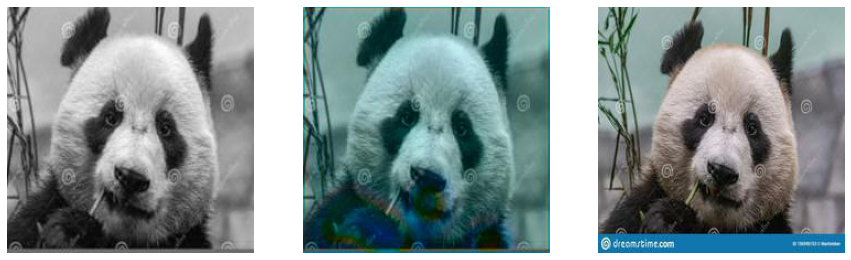

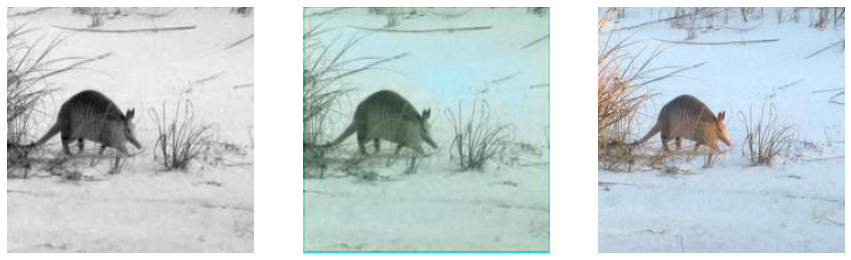

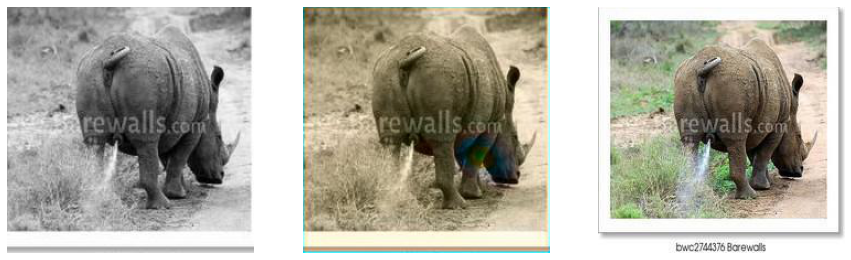

In [149]:
import matplotlib.image as mpimg
image_pairs = [
               ('outputs/color/img-0-epoch-23.jpg', 'outputs/gray/img-0-epoch-23.jpg','/content/drive/My Drive/Val/class/1.jpg'),
               ('outputs/color/img-1-epoch-22.jpg', 'outputs/gray/img-1-epoch-22.jpg','/content/drive/My Drive/Val/class/2.jpg'),
               ('outputs/color/img-2-epoch-29.jpg', 'outputs/gray/img-2-epoch-29.jpg','/content/drive/My Drive/Val/class/3.jpg'),
               #('outputs/color/img-9-epoch-28.jpg', 'outputs/gray/img-9-epoch-28.jpg')
               ]
for c, g,o in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  true = mpimg.imread(o)
  f, axarr = plt.subplots(1, 3)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[2].imshow(true)
  axarr[0].axis('off'), axarr[1].axis('off'),axarr[2].axis('off')
  plt.show()

In [82]:
from scipy.spatial import distance as dist
import cv2

## Test image 1

In [83]:
original_1 = cv2.imread('/content/drive/My Drive/Val/class/1.jpg')
historg_1 = cv2.calcHist([original_1],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
historg_1 = cv2.normalize(historg_1,historg_1).flatten()

In [109]:
pred_1 = cv2.imread('outputs/color/img-0-epoch-22.jpg')
histpred_1 = cv2.calcHist([pred_1],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
histpred_1 = cv2.normalize(histpred_1,histpred_1).flatten()

In [110]:
dist_inter_1 = cv2.compareHist(histpred_1,historg_1,cv2.HISTCMP_INTERSECT)

In [111]:
dist_chi_1 = cv2.compareHist(histpred_1,historg_1,cv2.HISTCMP_CHISQR)

In [112]:
dist_inter_1

1.5356007606242201

In [113]:
dist_chi_1

60.447829515233465

## Test image 2

In [124]:
original_2 = cv2.imread('/content/drive/My Drive/Val/class/2.jpg')
historg_2 = cv2.calcHist([original_2],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
historg_2 = cv2.normalize(historg_2,historg_2).flatten()

In [143]:
pred_2 = cv2.imread('outputs/color/img-1-epoch-18.jpg')
histpred_2 = cv2.calcHist([pred_2],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
histpred_2 = cv2.normalize(histpred_2,histpred_2).flatten()

In [144]:
dist_inter_2 = cv2.compareHist(histpred_2,historg_2,cv2.HISTCMP_INTERSECT)

In [145]:
dist_chi_2 = cv2.compareHist(histpred_2,historg_2,cv2.HISTCMP_CHISQR)

In [146]:
dist_inter_2

0.902611691646598

In [147]:
dist_chi_2

40.03162868506298

## Test image 3

In [72]:
original_3 = cv2.imread('/content/drive/My Drive/Val/class/3.jpg')
historg_3 = cv2.calcHist([original_3],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
historg_3 = cv2.normalize(historg_3,historg_3).flatten()

In [73]:
pred_3 = cv2.imread('outputs/color/img-2-epoch-29.jpg')
histpred_3 = cv2.calcHist([pred_3],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
histpred_3 = cv2.normalize(histpred_3,histpred_3).flatten()

In [74]:
dist_inter_3 = cv2.compareHist(histpred_3,historg_3,cv2.HISTCMP_INTERSECT)

In [75]:
dist_chi_3 = cv2.compareHist(histpred_3,historg_3,cv2.HISTCMP_CHISQR)

In [78]:
dist_inter_3

1.5992224851361243

In [79]:
dist_chi_3

53.060375354716896